# CT-213: Otimização de Hiperparâmetros com Metaheurísticas em Modelos de Classificação Financeira

## Instalação de Dependências e Imports

In [4]:
# Bibliotecas principais para manipulação de dados e machine learning
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-processamento e modelos clássicos
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score

# Otimização de hiperparâmetros
import optuna

# Utilitário para salvar modelo treinado
import joblib

# Bibliotecas para trabalhar com modelos transformers/bert
from transformers import pipeline, AutoTokenizer, AutoModel
import torch


## Carregamento e Preparação dos Dados

In [5]:
# Carregamento do dataset
df = pd.read_csv("FinancialPhraseBank.csv", sep=";")

# Manter apenas as colunas necessárias
df = df[['sentence', 'sentiment']]

# Remover linhas com valores ausentes (por segurança)
df = df.dropna().reset_index(drop=True)

# Conferir as primeiras linhas
print(df.head())

# Conferir o balanceamento das classes
print(df['sentiment'].value_counts())


                                            sentence sentiment
0  According to Gran , the company has no plans t...   neutral
1  For the last quarter of 2010 , Componenta 's n...  positive
2  In the third quarter of 2010 , net sales incre...  positive
3  Operating profit rose to EUR 13.1 mn from EUR ...  positive
4  Operating profit totalled EUR 21.1 mn , up fro...  positive
sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


## Análise exploratória básica

C:\Users\ITA\AppData\Local\Temp\ipykernel_8904\2353888135.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette='viridis')


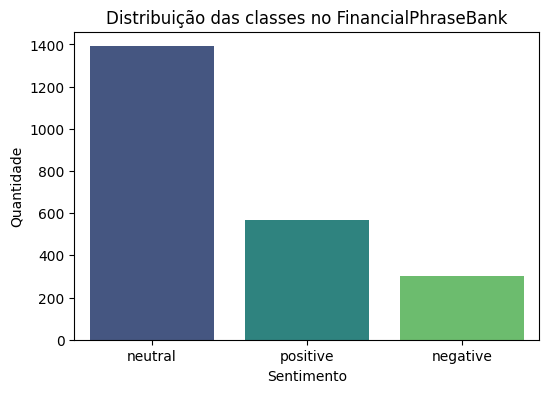


Exemplos de sentenças por classe:

--- NEUTRAL ---
['There have not been previous share subscriptions with 2004 stock options .'
 "The event can be followed on-line via Orion 's Finnish homepage at www.orion.fi as well as via the Kauppalehti Live web service at www.kauppalehti.fi/live ."]

--- POSITIVE ---
['These measures are expected to produce annual cost savings of EUR 1.5 million starting in 2007 .'
 'The last quarter was the best quarter of 2009 in net sales , and the operating margin rose to 12.2 % .']

--- NEGATIVE ---
['Earnings per share ( EPS ) in 2005 decreased to EUR1 .87 from EUR1 .89 in 2003 .'
 "Alma Media 's operating profit amounted to EUR 11.9 mn , down from EUR 15.0 mn a year earlier ."]



In [6]:
# Visualizar distribuição das classes
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index, palette='viridis')
plt.title('Distribuição das classes no FinancialPhraseBank')
plt.xlabel('Sentimento')
plt.ylabel('Quantidade')
plt.show()

# Exibir exemplos aleatórios de cada classe
print("\nExemplos de sentenças por classe:\n")
for sentiment in df['sentiment'].unique():
    print(f"--- {sentiment.upper()} ---")
    print(df[df['sentiment'] == sentiment]['sentence'].sample(2, random_state=42).values)
    print()


## Pipeline 1: TF-IDF + LogisticRegression (Baseline)

In [7]:
# Separar dados em treino e teste (usaremos o mesmo split para todas as abordagens)
X = df['sentence']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Pipeline clássico com parâmetros padrão
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,1))
model = LogisticRegression(max_iter=300)
pipeline_baseline = make_pipeline(vectorizer, model)

# Treinar e avaliar
pipeline_baseline.fit(X_train, y_train)
y_pred_baseline = pipeline_baseline.predict(X_test)

print("Relatório de Classificação - Baseline (TF-IDF + LogisticRegression):\n")
print(classification_report(y_test, y_pred_baseline, zero_division=0))


Relatório de Classificação - Baseline (TF-IDF + LogisticRegression):

              precision    recall  f1-score   support

    negative       0.88      0.61      0.72        61
     neutral       0.89      0.97      0.93       278
    positive       0.80      0.75      0.78       114

    accuracy                           0.87       453
   macro avg       0.86      0.78      0.81       453
weighted avg       0.87      0.87      0.86       453



## Pipeline 1: TF-IDF + LogisticRegression (Otimização de Hiperparâmetros com Optuna)

In [8]:
def run_pipeline_with_params(max_features=5000, C=1.0, ngram_range=(1,1), solver='lbfgs'):
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    model = LogisticRegression(C=C, solver=solver, max_iter=300)
    pipeline = make_pipeline(vectorizer, model)
    scores = cross_val_score(
        pipeline, X_train, y_train, cv=3, scoring='f1_macro'
    )
    return np.mean(scores)

def objective(trial):
    max_features = trial.suggest_int('max_features', 1000, 8000)
    C = trial.suggest_loguniform('C', 1e-4, 10.0)
    ngram_low = trial.suggest_int('ngram_low', 1, 2)
    ngram_high = trial.suggest_int('ngram_high', ngram_low, 3)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    ngram_range = (ngram_low, ngram_high)
    try:
        score = run_pipeline_with_params(
            max_features, C, ngram_range, solver
        )
    except Exception as e:
        print(e)
        return 0
    return score

# Rodando a otimização
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Melhores hiperparâmetros encontrados:", study.best_params)
print("Melhor F1-macro médio (validação cruzada):", study.best_value)


[I 2025-07-05 15:52:57,311] A new study created in memory with name: no-name-b118a0bc-8128-4fe7-bce4-2fd0c25f9886
C:\Users\ITA\AppData\Local\Temp\ipykernel_8904\1278927050.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10.0)
[I 2025-07-05 15:52:57,548] Trial 0 finished with value: 0.6303310915286864 and parameters: {'max_features': 6806, 'C': 0.6400478172349419, 'ngram_low': 1, 'ngram_high': 1, 'solver': 'liblinear'}. Best is trial 0 with value: 0.6303310915286864.
C:\Users\ITA\AppData\Local\Temp\ipykernel_8904\1278927050.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10.0)
[I 20

Melhores hiperparâmetros encontrados: {'max_features': 5343, 'C': 8.91000600003345, 'ngram_low': 1, 'ngram_high': 3, 'solver': 'liblinear'}
Melhor F1-macro médio (validação cruzada): 0.7948662982873572


## Avaliação do Pipeline TF-IDF + LogisticRegression Otimizado

In [9]:
# Recupera os melhores hiperparâmetros
best_params = study.best_params
best_ngram_range = (best_params['ngram_low'], best_params['ngram_high'])

# Monta e treina o pipeline otimizado
vectorizer_opt = TfidfVectorizer(
    max_features=best_params['max_features'],
    ngram_range=best_ngram_range
)
model_opt = LogisticRegression(
    C=best_params['C'],
    solver=best_params['solver'],
    max_iter=300
)
pipeline_optim = make_pipeline(vectorizer_opt, model_opt)
pipeline_optim.fit(X_train, y_train)

# Faz predições
y_pred_optim = pipeline_optim.predict(X_test)

print("Relatório de Classificação - Pipeline Otimizado (TF-IDF + LogisticRegression):\n")
print(classification_report(y_test, y_pred_optim, zero_division=0))


Relatório de Classificação - Pipeline Otimizado (TF-IDF + LogisticRegression):

              precision    recall  f1-score   support

    negative       0.90      0.77      0.83        61
     neutral       0.94      0.99      0.97       278
    positive       0.88      0.82      0.85       114

    accuracy                           0.92       453
   macro avg       0.91      0.86      0.88       453
weighted avg       0.92      0.92      0.92       453



## Análise gráfica/comparativa do TF-IDF (baseline vs. otimizado)

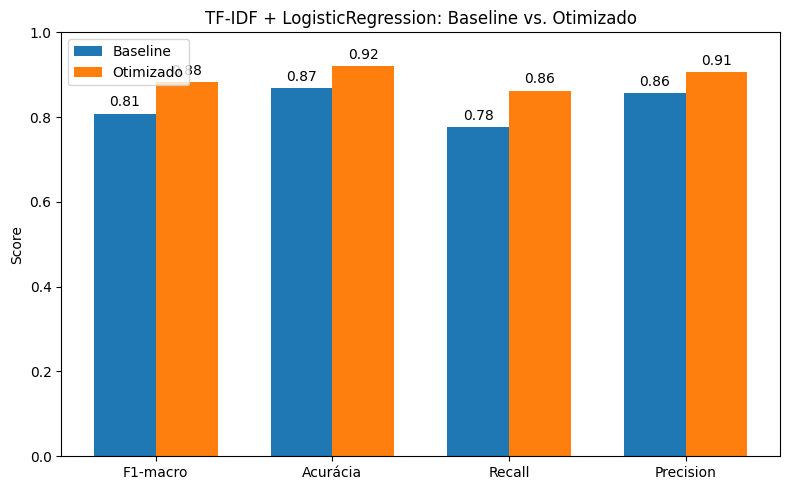

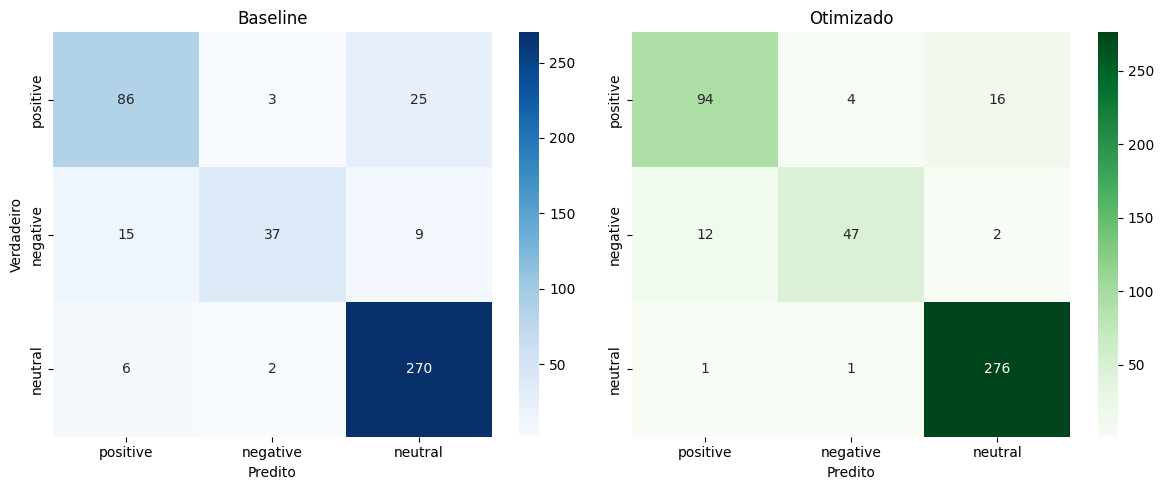

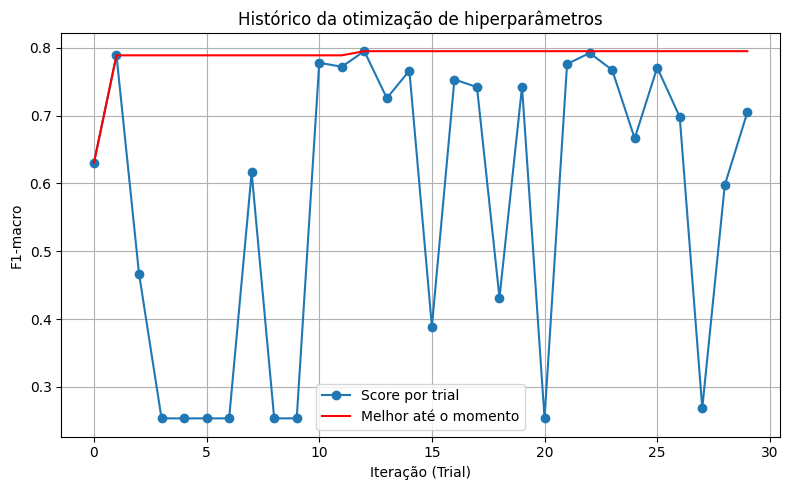

In [10]:
# Métricas agregadas para as duas versões
metrics = ['F1-macro', 'Acurácia', 'Recall', 'Precision']

baseline_scores = [
    f1_score(y_test, y_pred_baseline, average='macro'),
    accuracy_score(y_test, y_pred_baseline),
    recall_score(y_test, y_pred_baseline, average='macro'),
    precision_score(y_test, y_pred_baseline, average='macro')
]

optimized_scores = [
    f1_score(y_test, y_pred_optim, average='macro'),
    accuracy_score(y_test, y_pred_optim),
    recall_score(y_test, y_pred_optim, average='macro'),
    precision_score(y_test, y_pred_optim, average='macro')
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline')
rects2 = ax.bar(x + width/2, optimized_scores, width, label='Otimizado')

ax.set_ylabel('Score')
ax.set_title('TF-IDF + LogisticRegression: Baseline vs. Otimizado')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Matrizes de confusão lado a lado
labels = ['positive', 'negative', 'neutral']
cm_baseline = confusion_matrix(y_test, y_pred_baseline, labels=labels)
cm_optim = confusion_matrix(y_test, y_pred_optim, labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Baseline')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Verdadeiro')
sns.heatmap(cm_optim, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Otimizado')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()

# Evolução do score no Optuna
scores = [trial.value for trial in study.trials]
best_so_far = np.maximum.accumulate(scores)
plt.figure(figsize=(8,5))
plt.plot(scores, 'o-', label='Score por trial')
plt.plot(best_so_far, 'r-', label='Melhor até o momento')
plt.xlabel('Iteração (Trial)')
plt.ylabel('F1-macro')
plt.title('Histórico da otimização de hiperparâmetros')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Classificação direta com FinBERT (pipeline HuggingFace)

In [11]:
# Caso ainda não tenha instalado transformers e torch:
# !pip install transformers torch

from transformers import pipeline

# Carrega pipeline do FinBERT (pode demorar um pouco no primeiro uso)
finbert_pipe = pipeline("text-classification", model="ProsusAI/finbert")

# Aplica o pipeline diretamente nas frases do conjunto de teste
# (pode demorar um pouco dependendo do tamanho do conjunto de teste)
y_pred_finbert = []
for sentence in X_test:
    result = finbert_pipe(sentence)[0]['label'].lower()
    # Ajusta para o padrão de rótulos do dataset ('positive', 'negative', 'neutral')
    if result == 'positive':
        y_pred_finbert.append('positive')
    elif result == 'negative':
        y_pred_finbert.append('negative')
    else:
        y_pred_finbert.append('neutral')

print("Relatório de Classificação - FinBERT (pipeline direto):\n")
print(classification_report(y_test, y_pred_finbert, zero_division=0))


Device set to use cpu


Relatório de Classificação - FinBERT (pipeline direto):

              precision    recall  f1-score   support

    negative       0.95      0.97      0.96        61
     neutral       1.00      0.96      0.98       278
    positive       0.91      0.99      0.95       114

    accuracy                           0.97       453
   macro avg       0.95      0.97      0.96       453
weighted avg       0.97      0.97      0.97       453



## Análises gráficas: Classificação direta com FinBERT

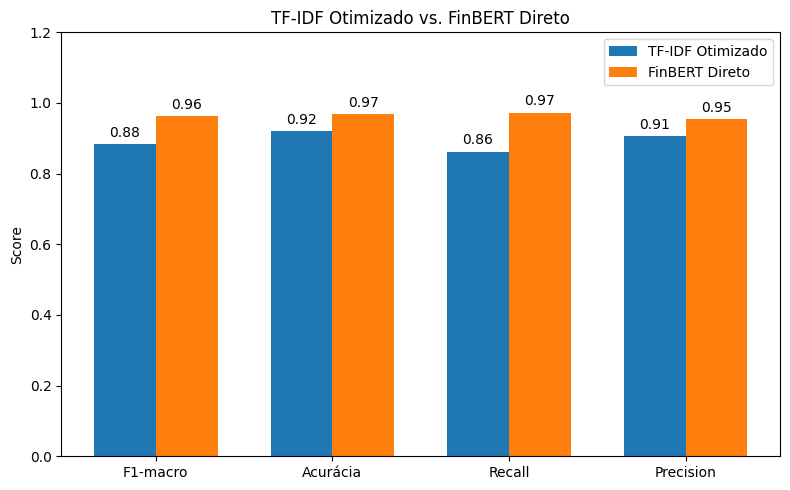

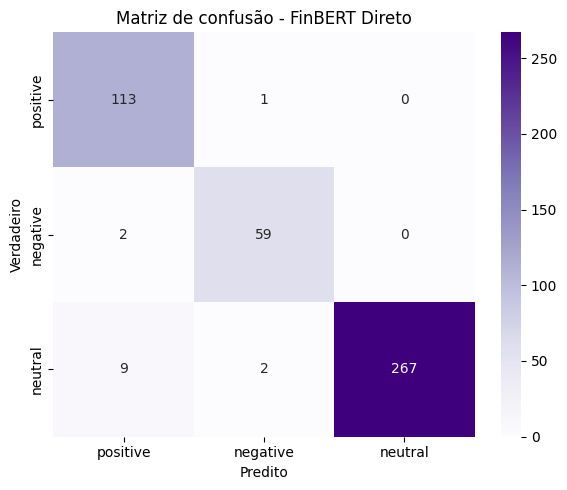

In [12]:
# Métricas do FinBERT direto
finbert_scores = [
    f1_score(y_test, y_pred_finbert, average='macro'),
    accuracy_score(y_test, y_pred_finbert),
    recall_score(y_test, y_pred_finbert, average='macro'),
    precision_score(y_test, y_pred_finbert, average='macro')
]

# Comparação (TF-IDF otimizado vs. FinBERT direto)
metrics = ['F1-macro', 'Acurácia', 'Recall', 'Precision']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, optimized_scores, width, label='TF-IDF Otimizado')
rects2 = ax.bar(x + width/2, finbert_scores, width, label='FinBERT Direto')

ax.set_ylabel('Score')
ax.set_title('TF-IDF Otimizado vs. FinBERT Direto')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.2)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Matrizes de confusão para o FinBERT direto
labels = ['positive', 'negative', 'neutral']
cm_finbert = confusion_matrix(y_test, y_pred_finbert, labels=labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm_finbert, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Matriz de confusão - FinBERT Direto')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.tight_layout()
plt.show()


## Extração de embeddings do FinBERT para treino/teste

In [13]:
from transformers import AutoTokenizer, AutoModel
import torch

# Carregar tokenizer e modelo do FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModel.from_pretrained("ProsusAI/finbert")

def get_finbert_embedding(text, tokenizer, model, device='cpu'):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        # Usa o embedding do [CLS] token
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

# (Opcional: use GPU se disponível)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# Gera embeddings para treino
print("Extraindo embeddings do FinBERT (treino)...")
X_train_embeddings = np.array([get_finbert_embedding(s, tokenizer, model, device) for s in X_train])

# Gera embeddings para teste
print("Extraindo embeddings do FinBERT (teste)...")
X_test_embeddings = np.array([get_finbert_embedding(s, tokenizer, model, device) for s in X_test])


Extraindo embeddings do FinBERT (treino)...
Extraindo embeddings do FinBERT (teste)...


## Classificador tradicional (baseline) sobre os embeddings do FinBERT

In [14]:
from sklearn.linear_model import LogisticRegression

# Treina um classificador tradicional (LogisticRegression) com parâmetros padrão
clf_emb_baseline = LogisticRegression(max_iter=300)
clf_emb_baseline.fit(X_train_embeddings, y_train)

# Faz predições no conjunto de teste
y_pred_emb_baseline = clf_emb_baseline.predict(X_test_embeddings)

print("Relatório de Classificação - Embeddings FinBERT + LogisticRegression (baseline):\n")
print(classification_report(y_test, y_pred_emb_baseline, zero_division=0))


Relatório de Classificação - Embeddings FinBERT + LogisticRegression (baseline):

              precision    recall  f1-score   support

    negative       0.98      0.97      0.98        61
     neutral       1.00      1.00      1.00       278
    positive       0.97      0.99      0.98       114

    accuracy                           0.99       453
   macro avg       0.99      0.98      0.99       453
weighted avg       0.99      0.99      0.99       453



## Otimização dos hiperparâmetros do classificador (LogisticRegression) sobre os embeddings do FinBERT com Optuna

In [15]:
def run_emb_classifier_with_params(C=1.0, solver='lbfgs'):
    clf = LogisticRegression(C=C, solver=solver, max_iter=300)
    scores = cross_val_score(
        clf, X_train_embeddings, y_train, cv=3, scoring='f1_macro'
    )
    return np.mean(scores)

def objective_emb(trial):
    C = trial.suggest_loguniform('C', 1e-4, 10.0)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    try:
        score = run_emb_classifier_with_params(C, solver)
    except Exception as e:
        print(e)
        return 0
    return score

study_emb = optuna.create_study(direction='maximize')
study_emb.optimize(objective_emb, n_trials=30)

print("Melhores hiperparâmetros encontrados (embeddings):", study_emb.best_params)
print("Melhor F1-macro médio (validação cruzada, embeddings):", study_emb.best_value)


[I 2025-07-05 15:58:00,380] A new study created in memory with name: no-name-d2fced5c-ab60-434b-b109-37c8ea695f67


C:\Users\ITA\AppData\Local\Temp\ipykernel_8904\2353785708.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10.0)
[I 2025-07-05 15:58:00,909] Trial 0 finished with value: 0.9697443057718682 and parameters: {'C': 0.0001301621541037088, 'solver': 'liblinear'}. Best is trial 0 with value: 0.9697443057718682.
C:\Users\ITA\AppData\Local\Temp\ipykernel_8904\2353785708.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-4, 10.0)
[I 2025-07-05 15:58:03,734] Trial 1 finished with value: 0.9707690748098018 and parameters: {'C': 0.0001520674776726265, 'solver': 'saga'}. Best is trial 1 with value: 0.970

Melhores hiperparâmetros encontrados (embeddings): {'C': 0.033437960927526156, 'solver': 'liblinear'}
Melhor F1-macro médio (validação cruzada, embeddings): 0.9771406033230208


## Avaliação do classificador otimizado nos embeddings do FinBERT

In [16]:
# Recupera os melhores hiperparâmetros encontrados pela busca
best_params_emb = study_emb.best_params

# Monta e treina o classificador otimizado
clf_emb_optim = LogisticRegression(
    C=best_params_emb['C'],
    solver=best_params_emb['solver'],
    max_iter=300
)
clf_emb_optim.fit(X_train_embeddings, y_train)

# Faz predições no conjunto de teste
y_pred_emb_optim = clf_emb_optim.predict(X_test_embeddings)

print("Relatório de Classificação - Embeddings FinBERT + LogisticRegression (otimizado):\n")
print(classification_report(y_test, y_pred_emb_optim, zero_division=0))


Relatório de Classificação - Embeddings FinBERT + LogisticRegression (otimizado):

              precision    recall  f1-score   support

    negative       0.98      0.97      0.98        61
     neutral       1.00      1.00      1.00       278
    positive       0.97      0.99      0.98       114

    accuracy                           0.99       453
   macro avg       0.99      0.98      0.99       453
weighted avg       0.99      0.99      0.99       453



## Análises gráficas: Embeddings FinBERT + LogisticRegression (baseline vs. otimizado)

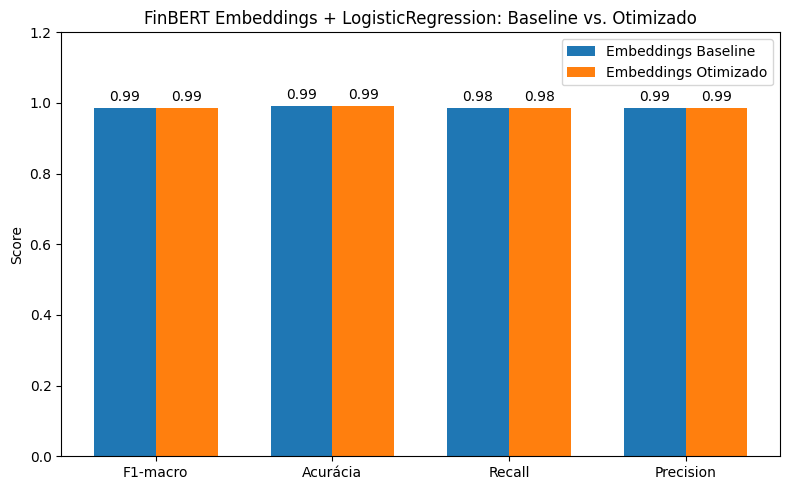

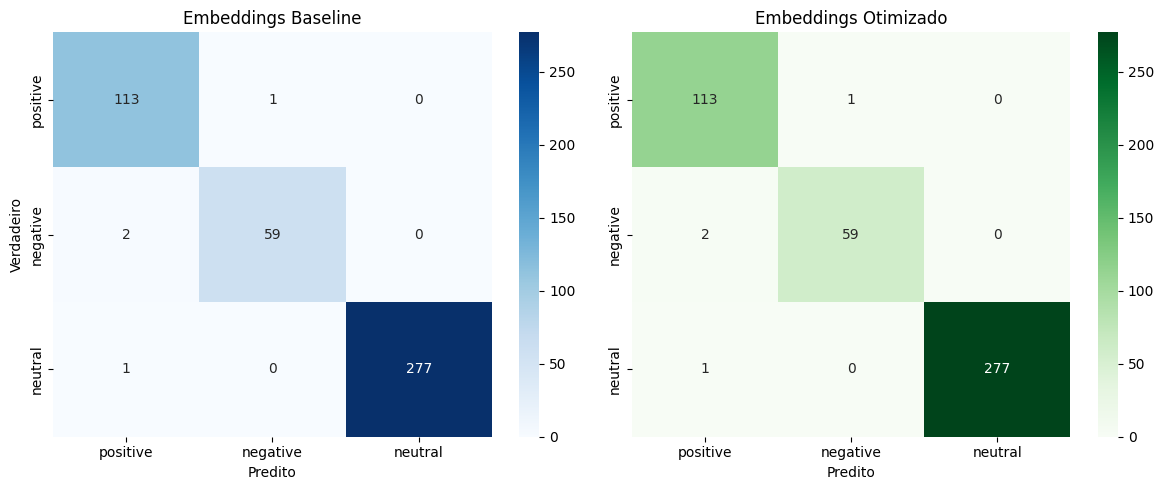

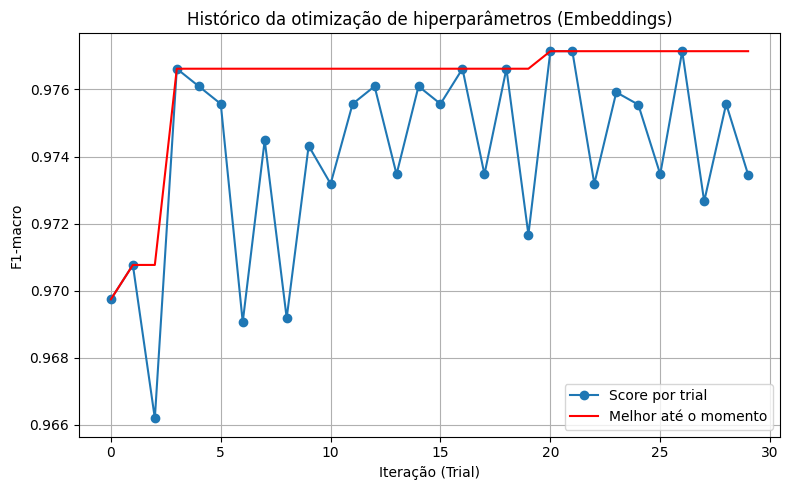

In [17]:
# Métricas para embeddings (baseline e otimizado)
emb_baseline_scores = [
    f1_score(y_test, y_pred_emb_baseline, average='macro'),
    accuracy_score(y_test, y_pred_emb_baseline),
    recall_score(y_test, y_pred_emb_baseline, average='macro'),
    precision_score(y_test, y_pred_emb_baseline, average='macro')
]

emb_optimized_scores = [
    f1_score(y_test, y_pred_emb_optim, average='macro'),
    accuracy_score(y_test, y_pred_emb_optim),
    recall_score(y_test, y_pred_emb_optim, average='macro'),
    precision_score(y_test, y_pred_emb_optim, average='macro')
]

metrics = ['F1-macro', 'Acurácia', 'Recall', 'Precision']
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, emb_baseline_scores, width, label='Embeddings Baseline')
rects2 = ax.bar(x + width/2, emb_optimized_scores, width, label='Embeddings Otimizado')

ax.set_ylabel('Score')
ax.set_title('FinBERT Embeddings + LogisticRegression: Baseline vs. Otimizado')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.2)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Matrizes de confusão
labels = ['positive', 'negative', 'neutral']
cm_emb_baseline = confusion_matrix(y_test, y_pred_emb_baseline, labels=labels)
cm_emb_optim = confusion_matrix(y_test, y_pred_emb_optim, labels=labels)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(cm_emb_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title('Embeddings Baseline')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Verdadeiro')
sns.heatmap(cm_emb_optim, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title('Embeddings Otimizado')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('')
plt.tight_layout()
plt.show()

# Evolução do score no Optuna para embeddings
scores_emb = [trial.value for trial in study_emb.trials]
best_so_far_emb = np.maximum.accumulate(scores_emb)
plt.figure(figsize=(8,5))
plt.plot(scores_emb, 'o-', label='Score por trial')
plt.plot(best_so_far_emb, 'r-', label='Melhor até o momento')
plt.xlabel('Iteração (Trial)')
plt.ylabel('F1-macro')
plt.title('Histórico da otimização de hiperparâmetros (Embeddings)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Comparação final entre todas as abordagens

Resumo comparativo das principais métricas:

                      Abordagem  F1-macro  Acurácia
0               TF-IDF Baseline  0.808187  0.867550
1              TF-IDF Otimizado  0.882524  0.920530
2                FinBERT Direto  0.962915  0.969095
3   Embeddings FinBERT Baseline  0.985338  0.991170
4  Embeddings FinBERT Otimizado  0.985338  0.991170


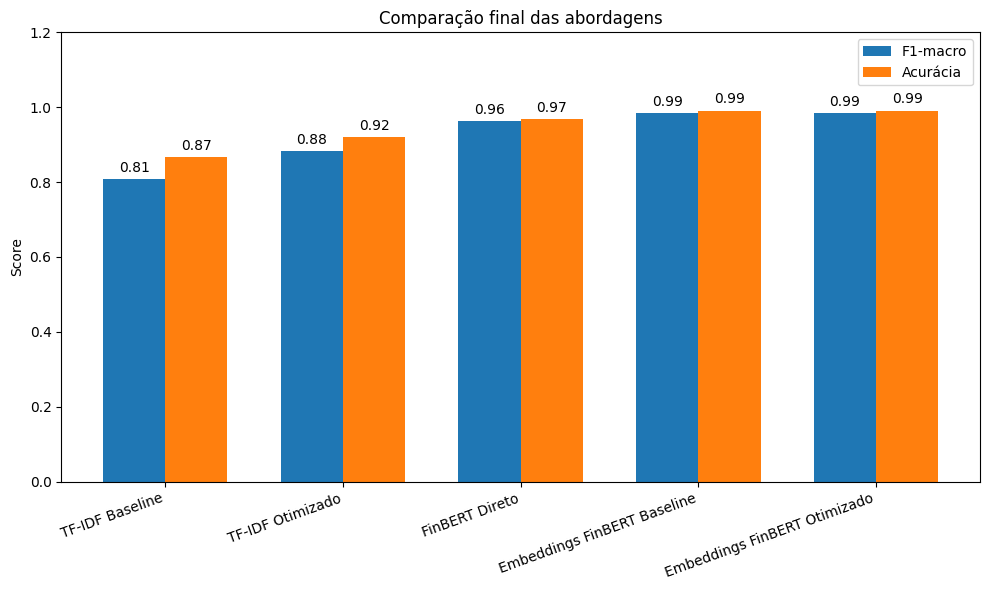

In [18]:
# Coleta de métricas principais (F1-macro e acurácia) de cada abordagem
results_df = pd.DataFrame({
    'Abordagem': [
        'TF-IDF Baseline',
        'TF-IDF Otimizado',
        'FinBERT Direto',
        'Embeddings FinBERT Baseline',
        'Embeddings FinBERT Otimizado'
    ],
    'F1-macro': [
        f1_score(y_test, y_pred_baseline, average='macro'),
        f1_score(y_test, y_pred_optim, average='macro'),
        f1_score(y_test, y_pred_finbert, average='macro'),
        f1_score(y_test, y_pred_emb_baseline, average='macro'),
        f1_score(y_test, y_pred_emb_optim, average='macro')
    ],
    'Acurácia': [
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred_optim),
        accuracy_score(y_test, y_pred_finbert),
        accuracy_score(y_test, y_pred_emb_baseline),
        accuracy_score(y_test, y_pred_emb_optim)
    ]
})

print("Resumo comparativo das principais métricas:\n")
print(results_df)

# Gráfico de barras para F1-macro e acurácia
x = np.arange(len(results_df))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, results_df['F1-macro'], width, label='F1-macro')
rects2 = ax.bar(x + width/2, results_df['Acurácia'], width, label='Acurácia')

ax.set_ylabel('Score')
ax.set_title('Comparação final das abordagens')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Abordagem'], rotation=20, ha='right')
ax.set_ylim(0, 1.2)
ax.legend()

for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Manual rápido de execução e dependências

## Manual rápido de execução

1. **Pré-requisitos:**  
   Certifique-se de ter os seguintes pacotes instalados (use pip conforme necessário):
pip install pandas numpy scikit-learn matplotlib seaborn joblib optuna torch transformers

2. **Arquivo de dados:**  
Coloque o arquivo `FinancialPhraseBank.csv` na mesma pasta do notebook.

3. **Execução:**  
Rode as células do notebook na ordem apresentada, do início ao fim.
- As células de extração de embeddings do FinBERT podem demorar um pouco.
- Se estiver usando Google Colab e desejar usar GPU, vá em `Ambiente de execução > Alterar tipo de hardware > GPU`.

4. **Saída:**  
O notebook irá exibir:
- Relatórios de classificação e matrizes de confusão para cada abordagem
- Gráficos de barras e evolução da otimização
- Comparação final entre as abordagens

5. **Salvando modelos:**  
Para salvar algum pipeline ou classificador treinado, basta usar:
```python
import joblib
joblib.dump(seu_modelo, 'nome_do_modelo.pkl')
```

6. **Reprodutibilidade:**
Todos os splits usam random_state=42 para garantir reprodutibilidade dos resultados.
